# Week 5 task

## Preparations:

In [1]:
#hide
!pip install -Uqq fastbook
!pip install dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
from fastai.collab import *
from fastai.tabular.all import *

### Checking paths and data:

In [4]:
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

[Path('.ipynb_checkpoints'),
 Path('fastbook'),
 Path('ml-latest'),
 Path('models'),
 Path('pulsar_data'),
 Path('storage'),
 Path('datasets')]

In [5]:
path = Path('pulsar_data')

In [6]:
path

Path('pulsar_data')

In [7]:
path.ls()

(#2) [Path('pulsar_data/pulsar_data_test.csv'),Path('pulsar_data/pulsar_data_train.csv')]

In [8]:
stars = pd.read_csv(path/'pulsar_data_train.csv', delimiter=',')
stars.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,...,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,...,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,...,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,...,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,...,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,...,20.618009,8.405008,76.291128,0.0


In [9]:
stars.columns

Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

In [10]:
dep_var = 'target_class'

In [11]:
procs = [Categorify, FillMissing]

In [12]:
cont,cat = cont_cat_split(stars, 1, dep_var=dep_var)

In [13]:
splits = RandomSplitter(valid_pct=0.2)(range_of(stars))

In [14]:
to = TabularPandas(stars, procs, cat, cont, y_names=dep_var, splits=splits)

In [15]:
len(to.train),len(to.valid)

(10023, 2505)

In [16]:
to.show(3)

,Excess kurtosis of the integrated profile_na,Standard deviation of the DM-SNR curve_na,Skewness of the DM-SNR curve_na,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
11596,False,False,False,107.210938,45.154190,0.467818,0.711132,2.305184,14.831991,8.909685,101.755646,0.0
11130,False,True,False,141.234375,55.450073,-0.453962,-0.073306,1.358696,18.436569,15.577542,330.120392,0.0
7779,False,False,False,108.953125,44.113464,0.553254,0.360724,1.582776,12.131278,13.035056,215.149445,0.0


In [17]:
to.items.head(3)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,...,target_class,Excess kurtosis of the integrated profile_na,Standard deviation of the DM-SNR curve_na,Skewness of the DM-SNR curve_na
11596,107.210938,45.154190,0.467818,0.711132,...,0.0,1,1,1
11130,141.234375,55.450073,-0.453962,-0.073306,...,0.0,1,2,1
7779,108.953125,44.113464,0.553254,0.360724,...,0.0,1,1,1


In [18]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Decision Tree:

In [19]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

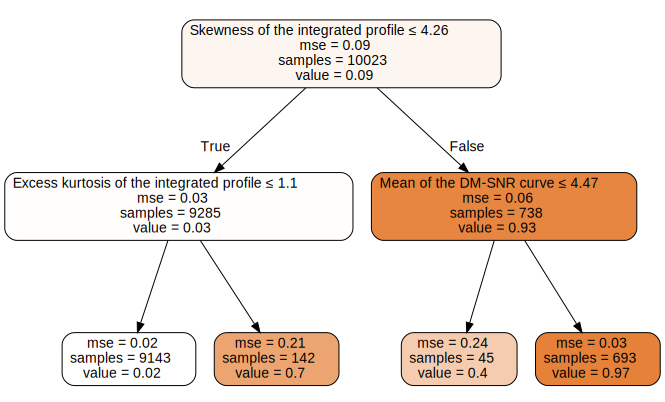

In [20]:
draw_tree(m, xs, size=17, leaves_parallel=True, precision=2)

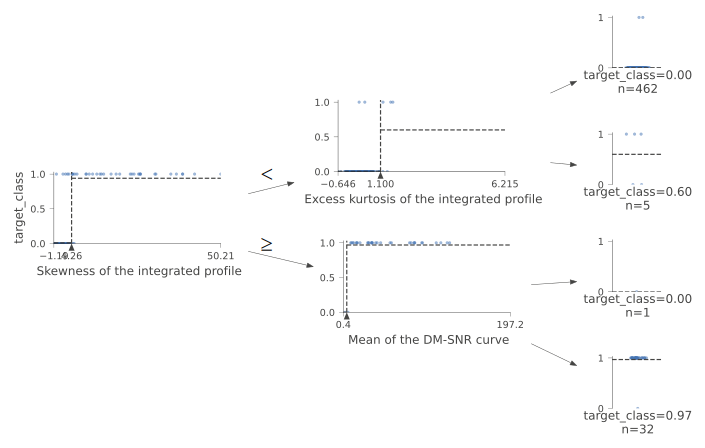

In [21]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [22]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [23]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [24]:
m_rmse(m, xs, y)

0.0

In [25]:
m_rmse(m, valid_xs, valid_y)

0.189547

#### Let's avoid overfitting?

In [26]:
m.get_n_leaves(), len(xs)

(252, 10023)

In [27]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.126968, 0.149233)

In [28]:
m.get_n_leaves()

78

## Random forest:

Reducing amount of samples from 200000 to 2000-4000, since we have only 10k data points.

In [29]:
def rf(xs, y, n_estimators=40, max_samples=2000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [30]:
m = rf(xs, y);

In [31]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.125211, 0.142789)

In [32]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [33]:
r_mse(preds.mean(0), valid_y)

0.142789

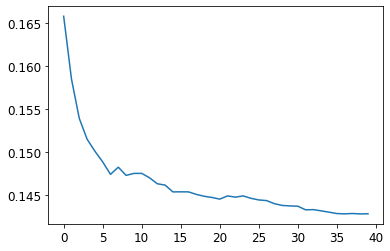

In [34]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [35]:
r_mse(m.oob_prediction_, y)

0.133996

## Let's do some interpretations:

### Feature importance:

In [36]:
def rf_feat_importance(m, stars):
    return pd.DataFrame({'cols':stars.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [37]:
fi = rf_feat_importance(m, xs)

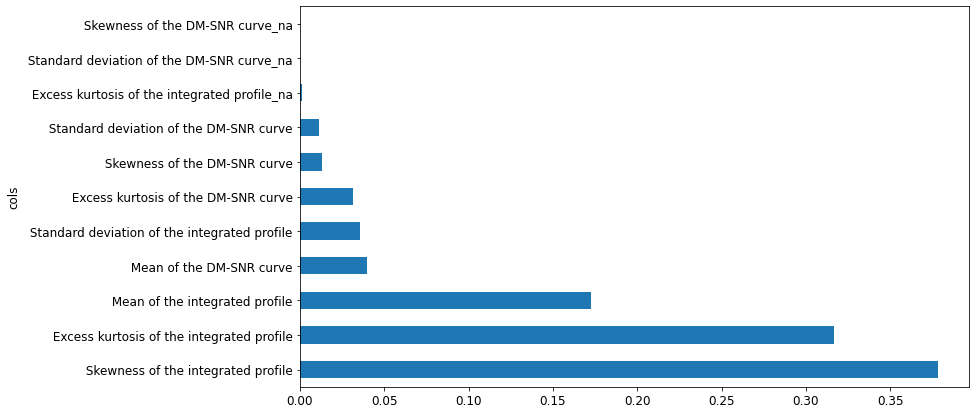

In [38]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [39]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

8

In [40]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [41]:
m = rf(xs_imp, y)

In [42]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.12536, 0.142761)

In [43]:
len(xs.columns), len(xs_imp.columns)

(11, 8)

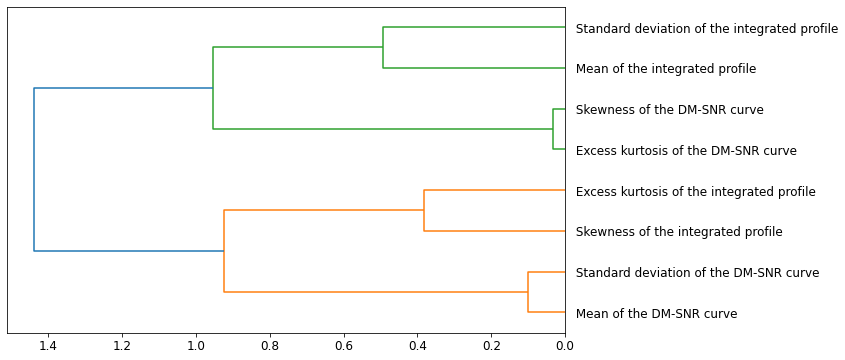

In [44]:
cluster_columns(xs_imp)

In [45]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=2000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [46]:
get_oob(xs_imp)

0.7776393207575182

In [47]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    ' Skewness of the DM-SNR curve', ' Excess kurtosis of the DM-SNR curve')}

{' Skewness of the DM-SNR curve': 0.7761080678387166,
 ' Excess kurtosis of the DM-SNR curve': 0.7767548637669563}

In [48]:
to_drop = [' Skewness of the DM-SNR curve', ' Excess kurtosis of the DM-SNR curve']
get_oob(xs_imp.drop(to_drop, axis=1))

0.7777460884513381

In [49]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [50]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.125572, 0.142654)

### Partial Dependence

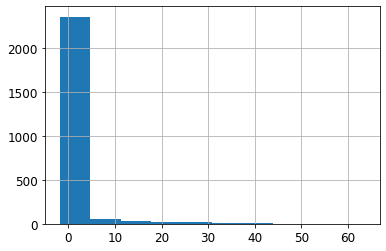

In [51]:
ax = valid_xs_final[' Skewness of the integrated profile'].hist()

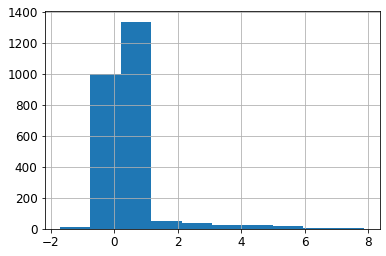

In [52]:
ax = valid_xs_final[' Excess kurtosis of the integrated profile'].hist()

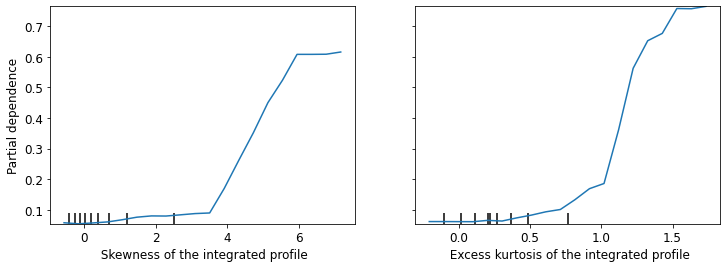

In [53]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, [' Skewness of the integrated profile',' Excess kurtosis of the integrated profile'],
                        grid_resolution=20, ax=ax);

### Waterfall chart:

In [54]:
#hide
! pip install treeinterpreter
!pip install waterfallcharts
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [55]:
row = valid_xs_final.iloc[:5]

In [56]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [57]:
prediction[0], bias[0], contributions[0].sum()

(array([0.64633658]), 0.09321249999999999, 0.55312408008658)

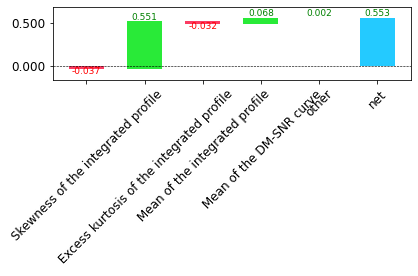

In [58]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.02, 
          rotation_value=45,formatting='{:,.3f}');

## Using neural net:

In [59]:
df_nn = pd.read_csv(path/'pulsar_data_train.csv', low_memory=False)

In [60]:
df_nn_final = df_nn[list(xs_final.columns) + [dep_var]]

In [61]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)
cont_nn,cat_nn

([' Skewness of the integrated profile',
  ' Excess kurtosis of the integrated profile',
  ' Mean of the integrated profile',
  ' Mean of the DM-SNR curve',
  ' Standard deviation of the integrated profile',
  ' Standard deviation of the DM-SNR curve'],
 [])

In [62]:
df_nn_final[cont_nn].nunique()

 Skewness of the integrated profile              12528
 Excess kurtosis of the integrated profile       10793
 Mean of the integrated profile                   7192
 Mean of the DM-SNR curve                         7224
 Standard deviation of the integrated profile    12510
 Standard deviation of the DM-SNR curve          11348
dtype: int64

In [63]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)
procs_nn

[fastai.tabular.core.Categorify,
 fastai.tabular.core.FillMissing,
 fastai.data.transforms.Normalize]

In [64]:
dls = to_nn.dataloaders(1024)
dls

In [65]:
y = to_nn.train.y
y.min(),y.max()

(0.0, 1.0)

In [66]:
from fastai.tabular.all import *

In [67]:
learn = tabular_learner(dls, y_range=(0,1), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0010000000474974513)

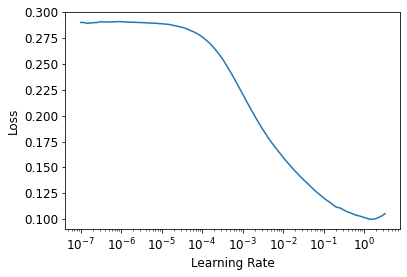

In [68]:
learn.lr_find()

In [69]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.245933,0.223104,00:00
1,0.158538,0.103220,00:00
2,0.105221,0.035700,00:00
3,0.077440,0.026011,00:00
4,0.061006,0.024291,00:00
5,0.050120,0.024007,00:00
6,0.042541,0.024055,00:00
7,0.037070,0.024224,00:00
8,0.032950,0.023420,00:00
9,0.029891,0.022271,00:00


In [70]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.149236

#### Random forest was this number: 0.142654

### Trying test set:

???

## Questions:

1. Is this a right way to use neural net for this particular dataset?
2. Is cont_cat_split relevant at all for all continuous params?